### Librairies

In [1]:
from bs4 import BeautifulSoup
from numpy.core.umath_tests import inner1d
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import pandas as pd
import numpy as np
import csv
import tqdm
from gensim.models import word2vec
import logging
import pickle
import json
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import nltk.data
import pandas as pd
import numpy as np
import pickle
import torch
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
from gensim.models import word2vec
from keras.preprocessing import sequence
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/home/min/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  
Using Theano backend.


## Pie chart
Le diagramme pie chart est pour voir la distribution de chaque classe

In [2]:
import pickle
with open("../dataset_without_3.p","rb") as f : 
    data = pickle.load(f)
data = data.sample(frac=1)

In [3]:
data.head()

,stars,text
12409,5,Love this place. When you spend multiple hours...
4638,5,A taste for taste. A bless in a continent wher...
817249,1,Disappointed by the quality of the food !! \r\...
390564,4,"Tasty, well presented food and attentive servi..."
195186,5,Very helpful. I had my brake light broken when...


In [4]:
print ('\nan exemple of review is:\n')
print (data["text"][1319], '\n')
print (data.shape)
print (data.columns)


an exemple of review is:

Went last week, and ordered a dozen variety. I didn't care for any of them, very dry, the frosting wasn't very good,even my 9 yr old daughter spit her cupcake out! 

(10000, 2)
Index(['stars', 'text'], dtype='object')


5    2500
4    2500
2    2500
1    2500
Name: stars, dtype: int64


Text(0.5,1,'Distribution of the four classes')

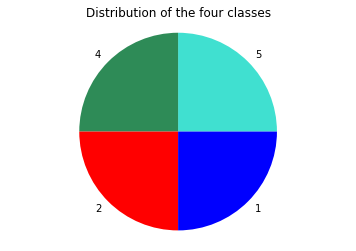

In [5]:
counts = data['stars'].value_counts()
print(counts)
colors = ['turquoise', 'seagreen','red','blue','yellow']
plt.pie(counts, labels=[5,4,2,1], colors=colors)
plt.axis('equal')
plt.title("Distribution of the four classes")

### Prétraitement des textes
Enlèvement des reviews vides et caractères spéciaux

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/min/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def sentence_to_wordlist(review):
        review_text = BeautifulSoup(review, "html.parser").get_text()
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        words = review_text.lower().split()
        return(words)
def review_to_sentences(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences : 
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence))
    return sentences

### Obtention du vocabulaire de ce corpus

In [8]:
reviews = data['text']
stars = data['stars']
voc = []
for ele in tqdm.tqdm(reviews) : 
    voc.extend(sentence_to_wordlist(ele))
voc = set(voc)
with open('vocabulaire_all.pkl', 'wb') as f : 
    pickle.dump(voc,f)

100%|██████████| 10000/10000 [00:00<00:00, 10523.97it/s]


### Obtention des phrases de ce corpus

In [9]:
sents = []
for ele in tqdm.tqdm(reviews) : 
    sents += review_to_sentences(ele,tokenizer)
pickle.dump(sents,open("sentences.p","wb"))

100%|██████████| 10000/10000 [00:04<00:00, 2472.75it/s]


### Chargement d'un WordEmbedding 

In [10]:
we = "word2vec"
if (we == "word2vec") :
    WordEm = word2vec.Word2Vec.load("300features_1minwords_10context")
    index2word_set = set(WordEm.wv.index2word)
    words_set = set(WordEm.wv.index2word)
    words = sentence_to_wordlist(reviews[1319])
    for word in words[:10]:
        print (word in index2word_set)
elif (we == "glove") : 
    with open("glove.840B.300d.txt", encoding='utf8') as f:
        words = set()
        WordEm = {}
        for line in tqdm.tqdm(f):
            values = line.split()
            curr_word = ''.join(values[:-300])
            words.add(curr_word)
            result = np.asarray(values[-300:], dtype='float32')
            WordEm[curr_word] = result
        words_set = words

True
True
True
True
True
True
True
True
True
True


In [11]:
len(words_set)

14380

### Classification binaire
les stars <=2 : négatif

les stars >=4 : positif

In [12]:
print (stars.shape)
stars_binary = np.zeros(stars.shape)
stars_binary[stars <= 2] = 0
stars_binary[stars > 2] = 1
print("num of positive reviews {}" .format((stars_binary == 1).sum()))
print("num of negative reviews {}" .format((stars_binary == 0).sum()))

(10000,)
num of positive reviews 5000
num of negative reviews 5000


### Représentation de chaque phrase sous la forme de wordembedding
chaque review est réprésenté par un tableau de dimension 100*300 (100 mot et chaque mot est représenté par un wordembedding de 300 dimensions) 

In [13]:
max_length = 32  # chaque review contient 32 mots : si len(review)> 32 : trunc ; sinon : padding
num_features = 300 #  dimension de wordembedding
index_from = 3
start = 1
oov = 2
word2index = { word : (i + index_from) for i,word in enumerate(words_set) }
index2word = { i : word for word, i in word2index.items() }
index2word[0] = '0'
index2word[1] = '1'
index2word[2] = '2'
# Pour les mots qui n'ont pas de wordembedding
padding_model = {}
padding_model['0'] = np.random.standard_normal(num_features)
padding_model['1'] = np.random.standard_normal(num_features)
padding_model['2'] = np.random.standard_normal(num_features)
reviews_words = []
for review in reviews:
    review_words = sentence_to_wordlist(review)
    review_words = [start] + [word2index[w] if (w in words_set) else oov for w in review_words]
    reviews_words.append(review_words)
# padding
reviews_words = sequence.pad_sequences(reviews_words, maxlen = max_length, padding='post', truncating='post')
print (reviews_words.shape)

(10000, 32)


### Séparation du corpus en deux parties 
    70% de l'ensemble d'entraînement, 10% de l'ensemble de validation et 20% de l'ensemble de test

In [14]:
data_matrix = np.empty((reviews_words.shape[0], max_length, num_features))
for i in range(reviews_words.shape[0]):
    data_matrix[i,:,:] = np.array([WordEm[index2word[ix]] if (index2word[ix] in words_set) else padding_model[index2word[ix]] for ix in reviews_words[i]])
labels = np.array(stars_binary)

In [15]:
index_0 = np.argwhere(labels==0)
index_1 = np.argwhere(labels==1)
train_index_0, valid_index_0,test_index_0 = np.split(index_0, [int(.7*len(index_0)), int(.8*len(index_0))])
train_index_1, valid_index_1,test_index_1 = np.split(index_1, [int(.7*len(index_1)), int(.8*len(index_1))])
train_index = []
train_index.extend(train_index_0)
train_index.extend(train_index_1)
valid_index = []
valid_index.extend(valid_index_0)
valid_index.extend(valid_index_1)
test_index = []
test_index.extend(test_index_0)
test_index.extend(test_index_1)

In [16]:
train_data = data_matrix[train_index]
valid_data = data_matrix[valid_index]
test_data = data_matrix[test_index]
train_labels = labels[train_index]
valid_labels = labels[valid_index]
test_labels = labels[test_index]

In [48]:
class CNN(nn.Module):
    def __init__(self,embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) 
                                    for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #embedded = x.unsqueeze(1)
        embedded = x
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
cnn = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
print(cnn)

CNN(
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)


In [94]:
optimizer = optim.Adam(cnn.parameters())

criterion = nn.BCEWithLogitsLoss()

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    
    return acc,rounded_preds.detach().numpy(),y.detach().numpy()

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predictionss = []
    true_balises = []
    model.train()
    
    for (x,y) in iterator:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        predictions = model(x).squeeze(1)
        y = y.view(50)
        loss = criterion(predictions, y)
        acc,tmp,labels_ = binary_accuracy(predictions,y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        predictionss.extend(tmp)
        true_balises.extend(labels_)
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predictionss,true_balises 


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    predictionss =[]
    true_balises = []
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.float()
            y = y.float()
            y = y.view(50)
            predictions = model(x).squeeze(1)
            loss = criterion(predictions,y)
            acc,tmp,labels_ = binary_accuracy(predictions, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            predictionss.extend(tmp)
            true_balises.extend(labels_)
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predictionss,true_balises

def plot_cm_matrix(solution,prediction,title) :
    cm = confusion_matrix(solution, prediction)
    df_cm = pd.DataFrame(cm, index = [i for i in "01"],columns = [i for i in "01"])
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cm,annot=True,fmt="d")
    plt.title(title)


In [50]:
torch.manual_seed(1)   
BATCH_SIZE = 50      
X_train= torch.from_numpy(train_data).double()
Y_train = torch.from_numpy(train_labels).double()
torch_dataset = Data.TensorDataset(X_train, Y_train)
train_d = Data.DataLoader(
    dataset=torch_dataset,      
    batch_size=BATCH_SIZE,      
    shuffle=True,             
    num_workers=2,  
)

X_valid= torch.from_numpy(valid_data).double()
Y_valid = torch.from_numpy(valid_labels).double()
torch_dataset = Data.TensorDataset(X_valid, Y_valid)
valid_d = Data.DataLoader(
    dataset=torch_dataset,      
    batch_size=BATCH_SIZE,      
    shuffle=True,             
    num_workers=2,             
)

X_test = torch.from_numpy(test_data).double()
Y_test = torch.from_numpy(test_labels).double()
torch_dataset = Data.TensorDataset(X_test,Y_test)
test_d = Data.DataLoader(
    dataset=torch_dataset,      
    batch_size=BATCH_SIZE,      
    shuffle=True,             
    num_workers=2,             
)

| Epoch: 01 | Train Loss: 0.275 | Train Acc: 88.49%| Val. Loss: 0.328 | Val. Acc: 87.10% |
| Epoch: 02 | Train Loss: 0.272 | Train Acc: 89.01%| Val. Loss: 0.332 | Val. Acc: 86.80% |
| Epoch: 03 | Train Loss: 0.278 | Train Acc: 88.01%| Val. Loss: 0.328 | Val. Acc: 86.70% |
| Epoch: 04 | Train Loss: 0.269 | Train Acc: 88.91%| Val. Loss: 0.319 | Val. Acc: 86.70% |
| Epoch: 05 | Train Loss: 0.258 | Train Acc: 89.33%| Val. Loss: 0.322 | Val. Acc: 86.80% |
| Epoch: 06 | Train Loss: 0.263 | Train Acc: 89.06%| Val. Loss: 0.331 | Val. Acc: 86.90% |
| Epoch: 07 | Train Loss: 0.256 | Train Acc: 89.53%| Val. Loss: 0.315 | Val. Acc: 87.20% |
| Epoch: 08 | Train Loss: 0.243 | Train Acc: 90.23%| Val. Loss: 0.313 | Val. Acc: 87.60% |
| Epoch: 09 | Train Loss: 0.241 | Train Acc: 90.13%| Val. Loss: 0.327 | Val. Acc: 86.90% |
| Epoch: 10 | Train Loss: 0.232 | Train Acc: 90.76%| Val. Loss: 0.316 | Val. Acc: 88.00% |
| Epoch: 11 | Train Loss: 0.232 | Train Acc: 90.23%| Val. Loss: 0.319 | Val. Acc: 87.10% |

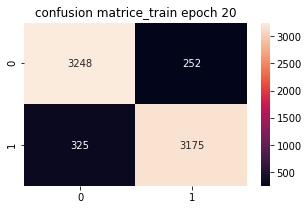

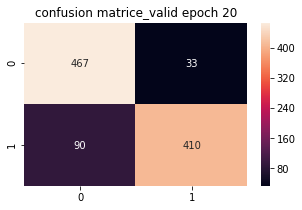

In [103]:
N_EPOCHS = 20
for epoch in range(N_EPOCHS):
    train_loss, train_acc,predictions_train,labels_train= train(cnn, train_d, optimizer, criterion)
    valid_loss, valid_acc,predictions_valid,labels_valid = evaluate(cnn, valid_d, criterion)
    if (epoch == N_EPOCHS-1) : 
        plot_cm_matrix(labels_train,predictions_train,"confusion matrice_train epoch "+str(epoch+1))
        plot_cm_matrix(labels_valid,predictions_valid,"confusion matrice_valid epoch "+str(epoch+1))
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    

| Test Loss: 0.323 | Test Acc: 86.70% |


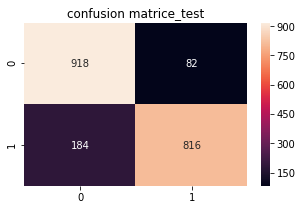

In [104]:
test_loss, test_acc, predictions_test,labels_test = evaluate(cnn, test_d, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
plot_cm_matrix(labels_test,predictions_test,"confusion matrice_test")